In [112]:
import matplotlib.pyplot as plt
import math
import random as ra
import numpy as np
import multiprocessing
from math import log

#getting sample from distribution
def Sample_normal(e,sigma,N=1):
    return((sigma*np.random.randn(1,N)+e)[0].tolist())

def Sample_geo(p,N=1):
    return((np.random.geometric(p,N))[0].tolist())
'''
mechanisms: we assume D is only changed when found a block
reward: reward for each round time
time: time consume for the pool find a new block
sp: variable cost or bidding price
N: how many round are test
part: miner takes how many part of the computation power
f: the fee taken by pool operator

D:expected time for mining
R:tolerance of miner
'''

def PPS(reward,time,sp,n,part,f):
    surplus=[(1-f)*(reward[i]-sp)*time[i]*part for i in range(n)]
    return(np.cumsum(surplus))

def PPLNS(reward,time,sp,n,D,part,f):
    income=[]
    prereserve=D
    i=0
    while prereserve>0:
        if time[i] <= prereserve:
            income.append((1-f)*(time[i]+(D-prereserve))*reward[i]*part)
            prereserve=prereserve-time[i]
            i=i+1
        else:
            break
    while i<n:
        income.append((1-f)*reward[i]*D*part)
        i=i+1
    surplus=[income[i]-time[i]*part*sp for i in range(n)]
    return (np.cumsum(surplus))

def Auction_patient(reward,time,sp,n,part,f):
    points=[t*part for t in time]
    surplus=[]
    reserve=0
    for i in range(n-1):
        step=sp*points[i]
        nominal=sp*((reserve/(1-f)+points[i])/(points[i]+reserve))
        if reward[i]<nominal:
            surplus.append(-1*step)
            reserve=reserve+points[i]*(1-f)
        else:
            surplus.append((reserve+points[i])*reward[i]-step)
            reserve=0
    surplus.append((reserve+points[i])*reward[n-1]-sp*points[n-1])
    return (np.cumsum(surplus))

def Auction_inpatient(reward,time,sp,n,part,f,R):
    surplus=[]
    points=[t*part for t in time]
    reserve=0
    balance=R-sp*points[0]
    for i in range(n-1):
        step=sp*points[i]
        nominal=sp*((reserve/(1-f)+points[i])/(points[i]+reserve))
        if reward[i]>=nominal:
            surplus.append((reserve+points[i])*reward[i]-step)
            balance=balance+surplus[-1]
            reserve=0
        elif reward[i]<nominal and balance>=step:
            surplus.append(-1*step)
            reserve=reserve+points[i]*(1-f)
            balance=balance-step
        else:
            surplus.append(-1*balance)
            reserve=reserve+balance*(1-f)/sp
            points[i+1]=0
            balance=0    
    surplus.append((reserve+points[n-1])*reward[n-1]-sp*points[n-1])
    return (np.cumsum(surplus))

def drawpicture(X,A,B,C,D,AN,BN,CN,DN,T):
    #plt.plot(x_ax,upbound,'red')
    l1,=plt.plot(X,A,"red",linewidth=0.7)
    l2,=plt.plot(X,B,"grey",linewidth=0.7)
    l3,=plt.plot(X,C,"blue",linewidth=0.7)
    l4,=plt.plot(X,D,"green",linewidth=0.7)
    plt.legend(handles=[l1, l2,l3,l4], labels=[AN, BN,CN,DN],  loc='best')
    plt.xlabel("round")
    plt.ylabel("reserve")
    plt.savefig(T+"-"+AN+"-"+CN+"-"+DN+".svg",dpi=1000)
    plt.show()
    
        

In [113]:
#simulating the utility of three kinds of miner mining in pools with different kinds of distribution method
#the reward is calculated that follows a normal distribution, time of finding block follows geometric distribution.
#three kinds of miner are: 1. sp>e, 2. sp=e, 3. sp<e.
#three kinds of distribution mechanism:1. PPS 2. PPLNS 3. auction model
def utility_test(f):
    #diffuculty and reward
    N=1000
    D0=100000
    B0=100000
    part=1.0/3
    D=Sample_normal(D0,0.03*B0,N)
    B=Sample_normal(B0,0.03*D0,N)
    # reward that found is as Reward, and fluctuation is around 3%
    Reward=[B[i]/D[i] for i in range(N)]
    # seconds for finding the block is Time_seq
    Time_seq=[Sample_geo(1.0/D[i]) for i in range(N)]
    #there are three kind of miners:a,b,c with different secret value but same speed.
    spa=1.03
    spb=1
    spc=0.97
    #Hence the surplus for miner is the benefit he get from miners his secret value.
    #1% computation power and 0.01 fee
    #for playerA:
    PPSbalance=PPS(Reward,Time_seq,spa,N,part,f)
    PPLNSbalance=PPLNS(Reward,Time_seq,spa,N,D0,part,f)
    Auction_p_balance=Auction_patient(Reward,Time_seq,spa,N,part,f)
    Auction_ip_balance=Auction_inpatient(Reward,Time_seq,spa,N,part,f,B0)
    drawpicture(range(N),PPSbalance,PPLNSbalance,Auction_p_balance,Auction_ip_balance," PPS","PPLNS","AMP","AMIP","player A:")
    #for playerB:
    PPSbalance=PPS(Reward,Time_seq,spb,N,part,f)
    PPLNSbalance=PPLNS(Reward,Time_seq,spb,N,D0,part,f)
    Auction_p_balance=Auction_patient(Reward,Time_seq,spb,N,part,f)
    Auction_ip_balance=Auction_inpatient(Reward,Time_seq,spb,N,part,f,B0)
    drawpicture(range(N),PPSbalance,PPLNSbalance,Auction_p_balance,Auction_ip_balance," PPS","PPLNS","AMP","AMIP","player B:")
    #for playerC:
    PPSbalance=PPS(Reward,Time_seq,spc,N,part,f)
    PPLNSbalance=PPLNS(Reward,Time_seq,spc,N,D0,part,f)
    Auction_p_balance=Auction_patient(Reward,Time_seq,spc,N,part,f)
    Auction_ip_balance=Auction_inpatient(Reward,Time_seq,spc,N,part,f,B0)
    drawpicture(range(N),PPSbalance,PPLNSbalance,Auction_p_balance,Auction_ip_balance," PPS","PPLNS","AMP","AMIP","player C:")
    return(B0,D0,B,D,Reward,Time_seq)

In [114]:
def reserve_updates(reserve, new,f,N):
    return([reserve[i]+new[i]*(1-f) for i in range(N)])
#the demand is higher than revenue
def auctiontable(sp,fc,sc,N,price):
    demand=0
    pricetable=[]
    i=-1
    while i<N-1:
        i=i+1
        tempprice=sp[i]
        if tempprice>price:
            return(pricetable)
        pricetable.append([tempprice*demand,demand,i,0])
        demand=demand+fc[i]
        pricetable.append([tempprice*demand,demand,i,1])
        demand=demand+sc[i]
        pricetable.append([tempprice*demand,demand,i,2])
    pricetable.append([price*demand,demand,i,3])
    return(pricetable)
        
def auction(supply,sp,fc,sc,f,N,price):
    auctable=auctiontable(sp,fc,sc,N,price)
    reserve=reserve_updates(sc,fc,f,N)
    L=len(auctable)
    if L==0:
        return(supply,reserve)
    for i in range(L):
        if supply<auctable[i][0]:
            cprice=auctable[i][0]/auctable[i][1]
            j=0
            while j<auctable[i][2]:
                reserve[j]=0
                j=j+1
            #print(reserve)
            if auctable[i][3]==1:
                part=supply-auctable[i-1][0]
                consume=part/cprice
                reserve[j]=reserve[j]-(1-f)*consume
            elif auctable[i][3]==2:
                part=supply-auctable[i-1][0]
                consume=part/cprice
                reserve[j]=sc[j]-consume
            return(0,reserve)
    j=0
    while j<=auctable[L-1][2]:
        reserve[j]=0
        j=j+1
    return(supply-auctable[L-1][0],reserve)
def reservesimu(B0,D0,B,D,Reward,Time_seq,f):
    #diffuculty and reward
    N=len(B)
    m=3
    #there are three kinds of miners:a,b,c with different secret value and the number of them are 100,100,100 with same speed
    reservepoints=[0 for i in range(m)]
    reservelog=[]
    poolReserve=[0]
    sp=[0.97,1,1.03]
    for i in range(N):
        R=poolReserve[-1]+B[i]
        points=[(1.0/m)*Time_seq[i] for j in range(m)]
        R,reservepoints=auction(R,sp,points,reservepoints,f,m,Reward[i])
        poolReserve.append(R)
        reservelog.append(reservepoints)
    print(sum(Time_seq)/D0)
    print(sum(B)/B0)
    drawpicture(range(N),poolReserve[1:],[i[0] for i in reservelog],[i[1] for i in reservelog],[i[2] for i in reservelog]," pool","a","b","c","reserve:")
            

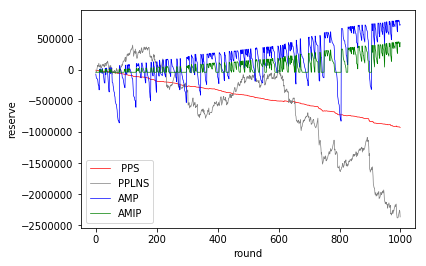

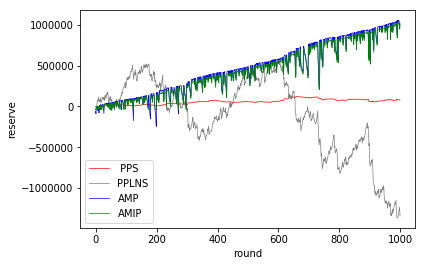

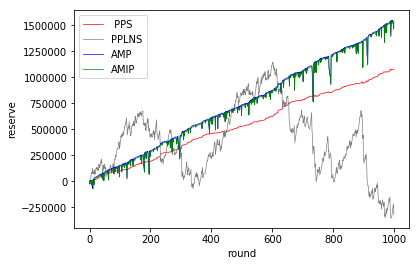

1021.85049
999.4124851728689


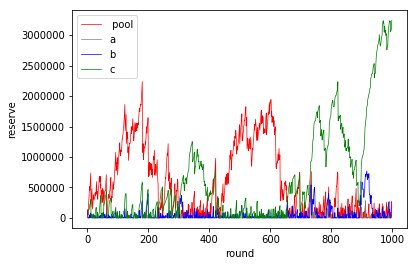

In [118]:
f=0.02
B0,D0,B,D,Reward,Time_seq=utility_test(f)
reservesimu(B0,D0,B,D,Reward,Time_seq,f)
